# Import Dependencies

In [73]:
import time
import sys
import os

# Get the absolute path to the src directory
src_path = os.path.abspath('../src')

# Add src_path to PYTHONPATH
if src_path not in sys.path:
    sys.path.append(src_path)

import matplotlib.pyplot as p
from matplotlib.lines import Line2D
import numpy as np
import xarray as xr

import pyvista as pv
pv.set_jupyter_backend('client')

from IPython.display import Image

import cedalion
import cedalion.sigproc.quality as quality
import cedalion.sigproc.artifact as artifact
import cedalion.dataclasses as cdc
import cedalion.datasets
import cedalion.geometry.registration # import icp_with_full_transform, find_spread_points
import cedalion.geometry.segmentation
from cedalion.geometry.photogrammetry.processors import ColoredStickerProcessor
from cedalion.geometry.landmarks import order_ref_points_6
import cedalion.imagereco.forward_model as fw
import cedalion.imagereco.tissue_properties
import cedalion.io
import cedalion.plots # import OptodeSelector
import cedalion.xrutils as xrutils
from cedalion.imagereco.solver import pseudo_inverse_stacked
from cedalion import units

# for dev purposes
%load_ext autoreload
%autoreload 2
#%matplotlib widget


prefix =  'C:/Users/avonl/OneDrive/Work/Research/projects/2024 - AvLtapCedalion/data/' # local
# prefix =  '/home/avonluh/data/' # cluster

## Data loading directories and files
# head segmentations
SEG_DATADIR = prefix+'mri/segmented/'
landmarks = 'landmarks.mrk.json'
# Finger Tapping fNIRS data
FT_DATADIR = prefix+'fnirs/data/'
dataset ='2024-02-05_013.snirf'
# Photogrammetric Scan
PG_DATADIR = prefix+'photogrammetry/scan.obj'
#PG_DATADIR = 'C://Users//avonl//My Drive (ibs.bifold@gmail.com)//photogrammetry//shift4.obj'
# Fluence Profile (precalculated)
FP_DATADIR = prefix+'mcx/'
TEMP_DATADIR = prefix+'tempdata/'
datafull = 'ftfull.snirf'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Finger Tapping Data

In [74]:
record = cedalion.io.read_snirf(FT_DATADIR+dataset)
rec = record[0]
# rename events
rec.stim.cd.rename_events(
        {"1": "Rest", 
         "2": "FTapping/Left", 
         "3": "FTapping/Right",
         "4": "BallSqueezing/Left",
         "5": "BallSqueezing/Right"}
    )
 
df = rec.stim

# Load Headmodel
Getting segmented MRI scans from AvL

In [53]:
masks={'csf': 'csf.nii', 'gm': 'gm.nii', 'scalp': 'scalp.nii', 'skull': 'skull.nii', 'wm': 'wm.nii'}

head = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = masks,
    landmarks_ras_file=landmarks
)

Plot loaded head

In [54]:
plt = pv.Plotter(notebook=True, off_screen=False)
plt.clear()  # Clear any previous plots

cedalion.plots.plot_surface(plt, head.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)

plt.show()


Widget(value='<iframe src="http://localhost:63419/index.html?ui=P_0x281869af550_10&reconnect=auto" class="pyvi…

# Register Probe to Headmodel using Photogrammetric scan

#### First plot the default probe 

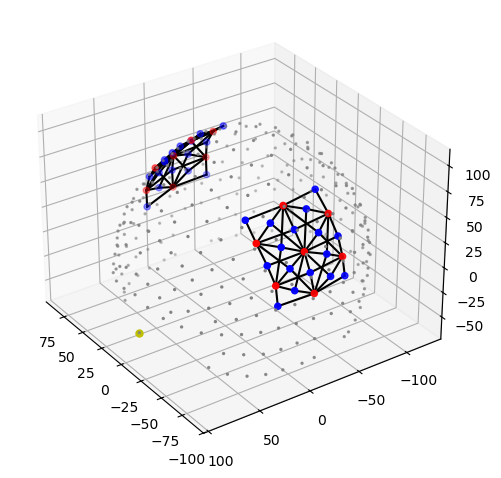

In [55]:
# plot montage
cedalion.plots.plot_montage3D(rec["amp"], rec.geo3d)

## Load and Display Photogrammetric Scan 

In [56]:
# load scan
scan = cedalion.io.read_einstar_obj(PG_DATADIR)

# find label stickers on the scan
PGprocessor = cedalion.geometry.photogrammetry.processors.ColoredStickerProcessor(
    colors={
        "O" : ((0.11, 0.21, 0.7, 1)), # (hue_min, hue_max, value_min, value_max)
        #"L" : ((0.25, 0.37, 0.35, 0.6))
    }
)
sticker_centers, normals, details = PGprocessor.process(scan, details=True)


[[ 172.506348  168.70253   570.348572]
 [-247.762009  317.902527  310.348602]
 [ 150.027954   86.302536  570.348572]
 ...
 [ 146.47406   217.239182  493.978607]
 [ 145.855286  217.494583  493.578003]
 [ 145.55806   217.509079  493.342957]]
[[153.826904 253.747421 570.348572]
 [152.226929 254.987106 570.348572]
 [151.426941 255.54277  570.348572]
 ...
 [147.931213 179.410263 446.350281]
 [146.85408  180.071243 446.188019]
 [148.198898 179.035706 446.32309 ]]
O (0.11, 0.21, 0.7, 1)
[0.0510395  0.14355842 0.31750923 0.23611748 0.22337348 0.08577019
 0.39936103 0.04708672 0.07661262 0.07265083 0.05569695 0.00931695
 0.12417121 0.07045661 0.07032844 0.06201362 0.10816765 0.32977119
 0.42587471 0.16597114 0.04891487 0.09873909 0.1192115  0.08660943
 0.30585273 0.08912666 0.01004768 0.00281426 0.15766289 0.15507026
 0.09780144 0.48502082 0.21359321 0.02668098 0.32618171 1.33795525
 0.08177803 0.00747566 0.34095757 0.20767707 0.32979805 2.35374077
 0.08937995 0.7041256  0.45662605 0.32529975 0

Plot 3DScan

In [57]:
pgplt = pv.Plotter(notebook=True, off_screen=False)
cedalion.plots.plot_surface(pgplt, scan, opacity=1.0)
cedalion.plots.plot_labeled_points(pgplt, sticker_centers, color="r")
cedalion.plots.plot_vector_field(pgplt, sticker_centers, normals)
pgplt.show(interactive = True)

Widget(value='<iframe src="http://localhost:63419/index.html?ui=P_0x28186bfbe10_11&reconnect=auto" class="pyvi…

### Optodes can be manually removed or added, if not all were found

In [58]:
visualizer = cedalion.plots.OptodeSelector(scan, sticker_centers, normals)
visualizer.plot()
visualizer.enable_picking()
cedalion.plots.plot_surface(visualizer.plotter, scan, opacity=1.0)
visualizer.plotter.show()

Widget(value='<iframe src="http://localhost:63419/index.html?ui=P_0x281902a7910_12&reconnect=auto" class="pyvi…

After selecting all optodes, update sticker_centers and normals:

In [59]:
sticker_centers = visualizer.points
normals = visualizer.normals if visualizer.normals is not None else normals

## Optode projection and landmark selection

In [60]:
optode_length = 22.6 * cedalion.units.mm

scalp_coords = sticker_centers.copy()
mask_optodes = sticker_centers.group == 'O'
scalp_coords[mask_optodes] = sticker_centers[mask_optodes] - optode_length*normals[mask_optodes]
#display(scalp_coords)

plt = pv.Plotter()
cedalion.plots.plot_surface(plt, scan, opacity=0.3)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r")
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="g")
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

Widget(value='<iframe src="http://localhost:63419/index.html?ui=P_0x2817981e050_13&reconnect=auto" class="pyvi…

### Landmark selection

In [61]:
plt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(plt, scan, opacity=1.0, pick_landmarks = True)
plt.show(interactive = True)

Widget(value='<iframe src="http://localhost:63419/index.html?ui=P_0x28179809050_14&reconnect=auto" class="pyvi…

### Get landmarks from the plot
Call *get_landmarks* from the previous cell and write into xarray
* 1st value - coordinates of picked landmarks
* 2nd - labels of corresponding landmarks

In [76]:
import tkinter as tk
from tkinter import messagebox

landmark_coordinates, landmark_labels = get_landmarks()

# write into Xarray
landmarks = xr.DataArray(
    np.vstack(landmark_coordinates),
    dims=["label", "digitized"],
    coords={
        "label": ("label", landmark_labels),
        "type": ("label", [cdc.PointType.LANDMARK]*5),
        "group": ("label", ["L"]*5),
    },
).pint.quantify("mm")


display(landmarks)

Magnitude,[[68.38550048762666 58.64876747408334 594.3798717390682] [17.875972670505902 256.35701282984974 516.3355792094609] [176.70221825675588 175.87820840874826 530.8607988980963] [38.073475600757774 107.15836156835911 489.4854981276969] [47.78662285722234 174.23209159870032 625.4493709996053]]
Units,millimeter


### Load montage info from snirf file and find transformation between  montage to landmarks

In [77]:
montage_elements = rec.geo3d
montage_elements = montage_elements.rename({"pos" : "aligned"})
#montage_elements
# find transformation between landmarks and montage elements
trafo = cedalion.geometry.registration.register_trans_rot(landmarks, montage_elements)

# apply the transformation to the montage elements
filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo)


### Coregistration: find and assign optode labels of scalp coordinates

In [78]:
scalp_coords = sticker_centers.copy()

# iterative closest point registration
idx = cedalion.geometry.registration.icp_with_full_transform(scalp_coords, 
                                                                            filtered_montage_elements_t, max_iterations = 100) 
# extract labels for detected optodes
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

# write labels to scalp_coords
scalp_coords = scalp_coords.assign_coords(label=labels)


## visualize results
# Green points represent optode centers
# Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)
plt = pv.Plotter()
cedalion.plots.plot3d(None, scan.mesh, filtered_montage_elements_t, None, plotter = plt) 
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="green", show_labels = True)
plt.show(interactive = True)


Widget(value='<iframe src="http://localhost:63419/index.html?ui=P_0x28056b649d0_16&reconnect=auto" class="pyvi…

### Update geo3D coordinates for the headmodel 

Transform coordinates to headmodel coordinates and snap to surface. Save them.

In [81]:
# update geo3D with accurate optode scalp positions and landmarks
geo3Dscan = cedalion.imagereco.forward_model.update_geo3D_from_scan(rec.geo3d, head, scalp_coords, landmarks)
# save geo3Dscan to disk
rec.geo3d = geo3Dscan

# save data
SAVEDATA = True
if SAVEDATA:
    cedalion.io.write_snirf(TEMP_DATADIR + datafull, rec)

# Preprocess Finger Tapping Data

In [83]:
## Prune with SNR threshold
snr_thresh = 10 # dB
snr, rec.masks["snr_mask"] = quality.snr(rec["amp"], snr_thresh)
# prune channels using the masks and the operator "all", which will keep only channels that pass all three metrics
rec["amp_pruned"], drop_list = quality.prune_ch(rec["amp"], [rec.masks["snr_mask"]], "all")

# Convert to OD
rec["od"] = cedalion.nirs.int2od(rec["amp"])

## find and remove movement artifacts
# define parameters for motion artifact detection. We follow the method from Homer2/3: "hmrR_MotionArtifactByChannel" and "hmrR_MotionArtifact".
t_motion = 0.5*units.s  # time window for motion artifact detection
t_mask = 1.0*units.s    # time window for masking motion artifacts (+- t_mask s before/after detected motion artifact)
stdev_thresh = 4.0      # threshold for standard deviation of the signal used to detect motion artifacts. Default is 50. We set it very low to find something in our good data for demonstration purposes.
amp_thresh = 5.0        # threshold for amplitude of the signal used to detect motion artifacts. Default is 5.
# to identify motion artifacts with these parameters we call the following function
rec.masks["ma_mask"] = artifact.id_motion(rec["od"], t_motion, t_mask, stdev_thresh, amp_thresh)
rec.masks["ma_mask"], ma_info = artifact.id_motion_refine(rec.masks["ma_mask"], 'by_channel')
# THIS IS WHERE WE WOULD APPLY SPLINE SG
# XXXXXXXXXXXXXXX
# XXXXXXXXXXXXXXX


# Convert to  HbO/HbR
dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )
rec["conc"] = cedalion.nirs.beer_lambert(rec["amp_pruned"], rec.geo3d, dpf)

# lowpass filter concentration data
rec["conc_freqfilt"] = rec["conc"].cd.freq_filter(
        fmin=0.01, fmax=0.5, butter_order=4
    )

mask collapsed to channel dimension


c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


# Plot a channel for quality control

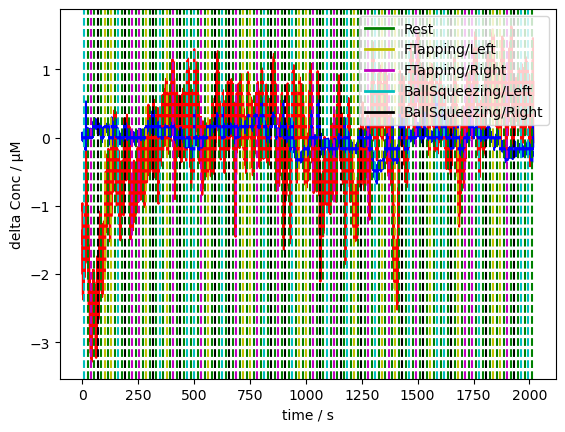

In [84]:
p.figure()
p.plot(rec["conc"].time, rec["conc"].sel(channel="S1D2", chromo="HbO"), "r-", label="HbO")
p.plot(rec["conc"].time, rec["conc"].sel(channel="S1D2", chromo="HbR"), "b-", label="HbR")

# Adding vertical stimulus lines
clr = {'Rest': 'g', 'FTapping/Left': 'y', 'FTapping/Right': 'm', 'BallSqueezing/Left': 'c', 'BallSqueezing/Right': 'k'}
for idx, onset in enumerate(rec.stim['onset']):
    # Use the index to get the corresponding element in the 'duration' column
    type = rec.stim.at[idx, 'trial_type']
    p.axvline(x=onset, color=clr[type], linestyle='--', label=type)

p.xlabel("time / s")
p.ylabel("delta Conc / µM")


# Defining custom legend handles and labels
custom_handles = [
    p.Line2D([0], [0], color='g', lw=2, label='Rest'),
    p.Line2D([0], [0], color='y', lw=2, label='FTapping/Left'),
    p.Line2D([0], [0], color='m', lw=2, label='FTapping/Right'),
    p.Line2D([0], [0], color='c', lw=2, label='BallSqueezing/Left'),
    p.Line2D([0], [0], color='k', lw=2, label='BallSqueezing/Right'),
]

# Adding the custom legend
p.legend(handles=custom_handles, loc='upper right')



# Plot Block Averages

mask collapsed to channel dimension


IndexError: index 56 is out of bounds for axis 0 with size 56

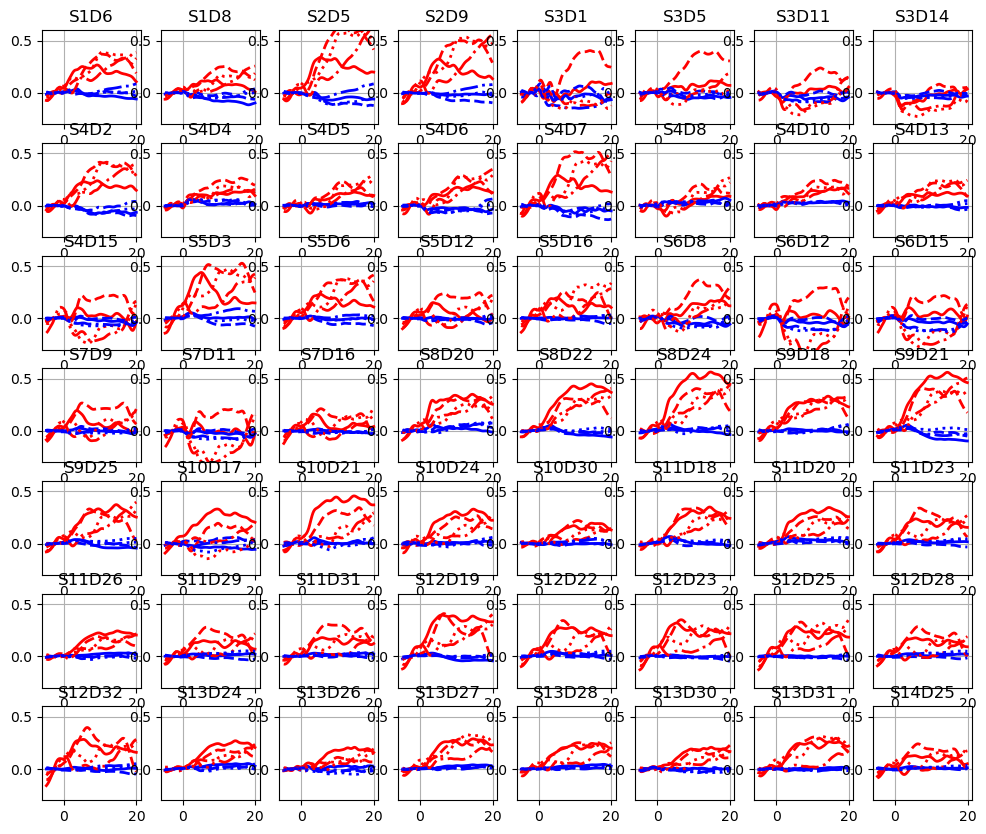

In [85]:
## keep only subset of long channels
sd_threshs = [2, 4.5]*units.cm # defines the lower and upper bounds for the source-detector separation that we would like to keep
ch_dist, rec.masks["sd_mask"] = quality.sd_dist(rec["conc_freqfilt"], rec.geo3d, sd_threshs)
rec["conc_freqfilt_LD"], masked_elements = xrutils.apply_mask(rec["conc_freqfilt"], rec.masks["sd_mask"], "drop", "channel")


# segment data into epochs
rec["cfepochs"] = rec["conc_freqfilt_LD"].cd.to_epochs(
        rec.stim,  # stimulus dataframe
        ["FTapping/Left", "FTapping/Right", "BallSqueezing/Left", "BallSqueezing/Right"], # select events. do not use "Rest"
        before=5,  # seconds before stimulus
        after=20,  # seconds after stimulus
)


# calculate baseline
baseline = rec["cfepochs"].sel(reltime=(rec["cfepochs"].reltime < 0)).mean("reltime")
# subtract baseline
rec["all_epochs_blcorrected_LD"] = rec["cfepochs"] - baseline

# group trials by trial_type. For each group individually average the epoch dimension
rec["blockaverage"] = rec["all_epochs_blcorrected_LD"] .groupby("trial_type").mean("epoch")


# Define line styles and trial types
line_styles = ["-", "--", "-.", ":"]
trial_types = ["FTapping/Left", "FTapping/Right", "BallSqueezing/Left", "BallSqueezing/Right"]

# Create custom legend handles
legend_handles = [Line2D([0], [0], color='k', lw=2, ls=ls, label=tt) for ls, tt in zip(line_styles, trial_types)]

# plot single channels
f, ax = p.subplots(7, 8, figsize=(12, 10))
ax = ax.flatten()
for i_ch, ch in enumerate(rec["blockaverage"].channel):
    for ls, trial_type in zip(line_styles, rec["blockaverage"].trial_type):
        ax[i_ch].plot(
            rec["blockaverage"].reltime,
            rec["blockaverage"].sel(chromo="HbO", trial_type=trial_type, channel=ch),
            "r",
            lw=2,
            ls=ls,
        )
        ax[i_ch].plot(
            rec["blockaverage"].reltime,
            rec["blockaverage"].sel(chromo="HbR", trial_type=trial_type, channel=ch),
            "b",
            lw=2,
            ls=ls,
        )
    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-0.3, 0.6)

# Add the legend to the first subplot
ax[0].legend(handles=legend_handles, title="Trial Types", loc='lower right')
p.tight_layout()

p.show() 

# DOT Image Reconstruction

## Optode Registration
Align the photogrammetrically registered optode positions with the scalp surface

In [87]:
LOAD_SCANCOORDS = True
# if we did the photogrammetric coregistration in a previous session and saved the results, load them here from our temp snirf file
if LOAD_SCANCOORDS:
    record = cedalion.io.read_snirf(TEMP_DATADIR + datafull)
    rec2 = record[0]
    rec.geo3d = rec2.geo3d


plt = pv.Plotter(notebook=True, off_screen=False)
cedalion.plots.plot_surface(plt, head.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, rec.geo3d, show_labels = True)
plt.show(interactive = True)

Widget(value='<iframe src="http://localhost:63419/index.html?ui=P_0x28095685090_18&reconnect=auto" class="pyvi…

## Simulate light propagation with MCX

In [49]:
fwm = cedalion.imagereco.forward_model.ForwardModel(head, rec.geo3d, rec._measurement_lists["amp"])

RUN_MCX = True

if RUN_MCX:
    fluence_all, fluence_at_optodes = fwm.compute_fluence()
    # save computed fluence data (xarrays) to disk to avoid having to re-run each time
    fluence_all.to_netcdf(FP_DATADIR+'AvL_fluence_all.nc')
    fluence_at_optodes.to_netcdf(FP_DATADIR+'AvL_fluence_at_optodes.nc')
else: # load precomputed data
    fluence_all = xr.open_dataset(FP_DATADIR+'AvL_fluence_all.nc')
    fluence_at_optodes = xr.open_dataset(FP_DATADIR+'AvL_fluence_at_optodes.nc')

simulating fluence for D21. 1 / 46
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 1


RuntimeError: CUDA driver version is insufficient for CUDA runtime version

: 

: 

: 